# Using GhostFaceNet - The new SOTA Lightweight Face Recognition

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir,root_img_path):
        print(model_interf)
        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb)
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
            emb, img_class = embs.astype("float32"), imm_classes.astype("int")
        else:
            img_shape = (112, 112)
            imgs = pd.read_csv('../train.csv')['image'].tolist()
            labels = pd.read_csv('../train.csv')['label'].tolist()
            embs = [] # list of embeddings
            classes = []
            names = []
            for i,img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path,img_path)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0)

                emb = self.model_interf(img)
                emb = normalize(np.array(emb).astype("float32"))[0]
                img_class = int(labels[i])
                classes.append(img_class)
                embs.append(emb)
                filename = os.path.basename(img_path)
                names.append(filename)

            np.savez(output_dir, embs=embs, imm_classes=classes, filenames=names)

        return emb, img_class, filename
    
    def add_to_embedding(img_path,int_label,output_dir):
        save_embeddings = output_dir
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, names = aa["embs"], aa["imm_classes"], aa["filenames"]
            embs, classes = embs.astype("float32"), imm_classes.astype("int")
            ## generate embedding of a single image
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)
            # single embeeding
            semb = self.model_interf(img)
            semb = normalize(np.array(semb).astype("float32"))[0]
            filename = os.path.basename(img_path)
            ## append
            embs.append(semb)
            classes.append(int_label)
            names.append(filename)
            
            ## save
            np.savez(output_dir, embs=embs, imm_classes=classes, filenames=names)
            
        
    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes)
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1])
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            pos_pick_cond = self.imm_classes == register_id
            pos_embs = self.embs[pos_pick_cond]
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]

            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist)
            register_base_embs = np.vstack([register_base_embs, register_base_emb])
        register_base_dists = np.array(register_base_dists).T
        # cosine similarity from one image to each class
        print(register_base_dists.shape)
        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ",register_ids.shape)
        print("self.imm_classes shape: ",self.imm_classes.shape)
        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape) # array co 1 nghin cot, gia tri tai cot label =1 
        
        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape)
        # turn it into a binary classification
        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists]) #distance tai cot co label va k co label 
        return accuracy,score,label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")

        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig

In [4]:
demo_image = Eval_image("../checkpoints/GhostFaceNet_W1.3_S1_ArcFace.h5", "../train", output_dir="../embeddings/vn2.npz",root_img_path="../train")

../checkpoints/GhostFaceNet_W1.3_S1_ArcFace.h5

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK

Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 4000, compute capability 7.5


begin serving

>>>> Reloading from backup: ../embeddings/vn2.npz


In [5]:
accuracy, score, label = demo_image.do_evaluation()

>>>> [base info] embs: (4720, 512) imm_classes: (4720,) register_ids: (1000,)


Evaluating: 100%|██████████| 1000/1000 [00:08<00:00, 122.39it/s]


(4720, 1000)

register_ids shape:  (1000,)

self.imm_classes shape:  (4720,)

(4720, 1000)

(4720,)

(4715280,)


In [6]:
accuracy

0.9330508474576271

|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |    0.01 |      0.1 |

|:----|---------:|---------:|---------:|---------:|--------:|---------:|

| TPR | 0.500212 | 0.686017 | 0.841314 | 0.935593 | 0.98178 | 0.998517 |


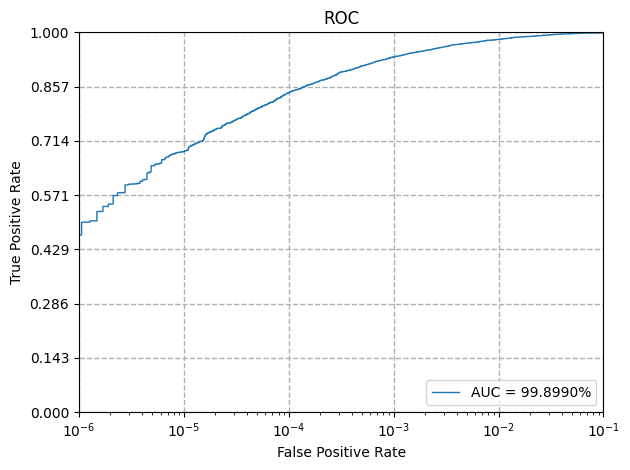

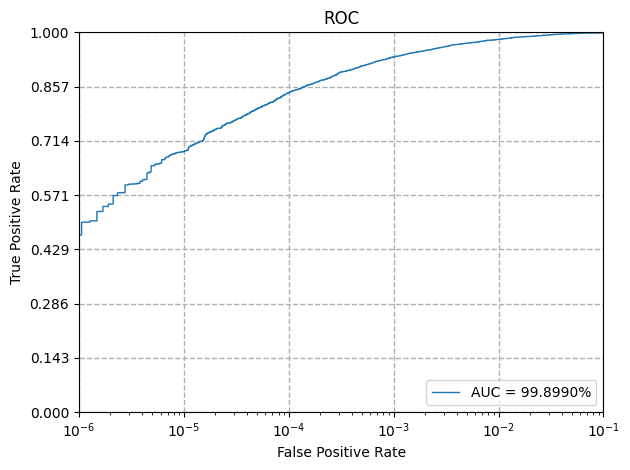

In [7]:
plot_tpr_far(score, label, new_figure=True, label_prefix="")